# Espectrograma e Shepard tone

O espectrograma é uma forma de visualizar as características de um sinal no tempo e frequência. Para criar um espectrograma toma-se janelas de um sinal ao longo do tempo (podendo haver sobreposição entre elas) e calcula-se a FFT de cada trecho. O módulo de cada uma das FFTs é armazenado como uma coluna de uma matriz. 

![spectrogram scheme](imgs/spectrogram_scheme.png)

Ao final teremos uma matriz onde o tempo decorre ao longo das linhas e ao longo das colunas temos a composição espectral do sinal. Podemos visualizar a imagem usando uma escala de cores para identificar as amplitudes.

Um dos parâmetros necessários para fazer um espectrograma é o tamanho da janela temporal. O tamanho da janela define qual é a resolução no tempo e frequência (veja mais sobre o princípio da incerteza de Heisenberg: https://en.wikipedia.org/wiki/Uncertainty_principle#Signal_processing).

![time freq resolution](imgs/spectrogram_time_freq_resolution.png)

Leia mais sobre espectrograma: https://en.wikipedia.org/wiki/Spectrogram

A função para fazer um espectrograma é *specgram* e faz parte do pacote *signal*.

In [1]:
pkg load signal
help specgram

'specgram' is a function from the file /usr/share/octave/packages/signal-1.4.0/specgram.m

 -- Function File: specgram (X)
 -- Function File: specgram (X, N)
 -- Function File: specgram (X, N, FS)
 -- Function File: specgram (X, N, FS, WINDOW)
 -- Function File: specgram (X, N, FS, WINDOW, OVERLAP)
 -- Function File: [S, F, T] = specgram (...)

     Generate a spectrogram for the signal X.  The signal is chopped
     into overlapping segments of length N, and each segment is windowed
     and transformed into the frequency domain using the FFT. The
     default segment size is 256.  If FS is given, it specifies the
     sampling rate of the input signal.  The argument WINDOW specifies
     an alternate window to apply rather than the default of 'hanning
     (N)'.  The argument OVERLAP specifies the number of samples overlap
     between successive segments of the input signal.  The default
     overlap is 'length (WINDOW)/2'.

     If no output arguments are given, the spectrogram is 

Para ilustrar nosso primeiro espectrograma, vamos usar o exemplo condito do *help* da função.

specgram example 1:
 Fs=1000;
 x = chirp([0:1/Fs:2],0,2,500);  # freq. sweep from 0-500 over 2 sec.
 step=ceil(20*Fs/1000);    # one spectral slice every 20 ms
 window=ceil(100*Fs/1000); # 100 ms data window

 ## test of automatic plot
 [S, f, t] = specgram(x);
 specgram(x, 2^nextpow2(window), Fs, window, window-step);



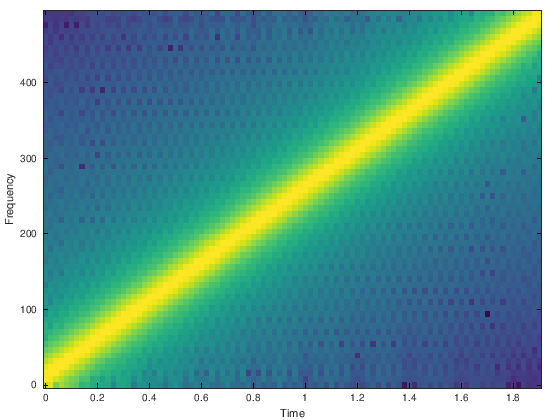

In [2]:
demo specgram

Vamos agora ver o segundo exemplo com algumas adapatações.

Mostraremos o espectrograma da elocução da palavra *multimedia*. Iremos grampear (clip) o espectrograma nas baixas e altas amplitudes, para melhor visualização. Iremos também nos restringir à faixa de interesse da fala (até 4kHz).

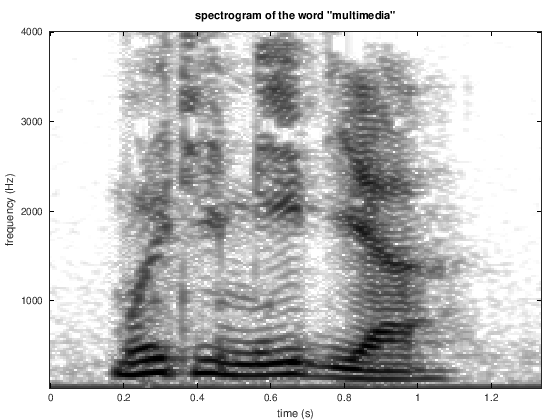

In [30]:
system("wget -q https://upload.wikimedia.org/wikipedia/commons/d/d5/De-Multimedia.ogg -O /tmp/multimedia.ogg");
[x, fs] = audioread("/tmp/multimedia.ogg");
% defining specgram parameters
step = fix(5*fs/1000);     # one spectral slice every 5 ms
window = fix(40*fs/1000);  # 40 ms data window
fftn = 2^nextpow2(window); # next highest power of 2
[S, f, t] = specgram(x, fftn, fs, hamming(fftn), window-step);
% max frequency we want to show
fmax = 4000; nf = floor(fftn*fmax/fs);
S = abs(S(1:nf,:)); # magnitude in range 0<f<=4000 Hz.
S = S/max(S(:));           # normalize magnitude so that max is 0 dB.
S = max(S, 10^(-35/10));   # clip below -35 dB.
S = min(S, 10^(-3/10));    # clip above -3 dB.
imagesc (t, f(1:nf), log(flipud(S)));    # display in log scale
% we used flipud above, but we could also use the following:
% set (gca, "ydir", "normal"); # put the 'y' direction in the correct direction
title('spectrogram of the word "multimedia"');
% fixing y-axis ticks
set(gca,'ytick',[0:fmax/4:fmax]);
yl = get(gca,'yticklabel');
set(gca,'yticklabel',yl(end:-1:1));
xlabel('time (s)'); ylabel('frequency (Hz)');
% inverted grayscale colormap
cmap = repmat([255:-1:0]'/255,1,3); colormap(cmap);

## Shepard Tone

Por fim, vamos criar um tom de Shepard. Ele consiste em uma superposição de tons com frequências crescentes, de forma que após um ciclo o tom mais baixo alcança a frequência inicial do segundo tom; o segundo tom alcança a frequência inicial do terceiro; e assim por diante (visualizando o espectrograma fica fácil entender como funciona). 

Leia mais aqui: https://en.wikipedia.org/wiki/Shepard_tone

Vamos então criar uma função para gerar um tom de Shepard.

In [31]:
function w = shepardtone(fmin=200,fmax=4000,n=12,d=1,r=3)
  % shepardtone(fmin,fmax,n,d,r)
  % w = shepardtone(fmin,fmax,n,d,r)
  %
  % fmin: lowest frequency (Hz)
  % fmax: highest frequency (Hz)
  % n: number of tones
  % d: duration (one cycle) (s)
  % r: repeats

  if fmax <= fmin, error('fmax must be greater than fmin'); endif

  fs = 2*fmax; %44100;
  t = 0: 1/fs : d-1/fs; % timestamps for each sample point

  % find ratio between the n tones
  % fmin * frt^n = fmax
  frt = exp( log(fmax/fmin)/n );
  % create n starting frequencies of the tones
  fstart = fmin * frt.^[0:n-1]';
  % at the end of the interval, each tone must reach in frequency the next tone at time zero
  % we need to find the tone increase ratio
  % f_i tir^nsamples = f_{i+1} = f_i * frt
  nsamples = fs*d;
  tir = exp( log(frt)/nsamples );
  f = fstart * tir.^[0:nsamples-1];
  % phase of each tone 
  p = 2*pi * cumsum(f, 2) / fs;
  % make last column a multiple of 2*pi for phase continuity
  p = diag((2*pi*floor(p(:,end)/(2*pi))) ./ p(:,end)) * p;
  % create sin wave for each tone
  s = sin(p);
  % mixing amplitudes from raised-cosine curve over frequency
  af = [0:1/n:1-1/n]' + [1:nsamples]*1/(n*nsamples);
  a =0.5-0.5*cos(2*pi*af);
  % mix tones and normalizing
  w = sum(s .* a)/n;
  % replicate r times
  w = repmat(w, 1, r);

  if nargout == 0,
    step=ceil(20*fs/1000);    % one spectral slice every 20 ms
    window=ceil(100*fs/1000); % 100 ms data window
    specgram(w, 2^nextpow2(window), fs, window, window-step);
    sv = yes_or_no ('save file?');
    if sv, filename = input ('file name: ','s'); audiowrite ( filename, w, fs);  endif;
    ply = yes_or_no ('play sound?');
    if ply, sound(w,fs); endif;
  endif

endfunction

save file? (yes_or_no) no
play sound? (yes_or_no) yes
ALSA lib pcm_dsnoop.c:638:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1108:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePt

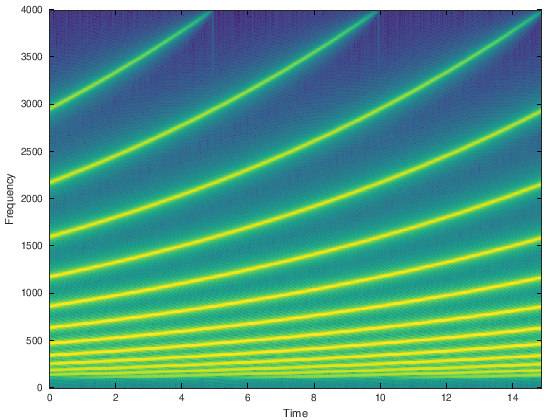

In [32]:
shepardtone(100,4000,12,5,3);